# BOUNDARY ABLATION

This notebook demonstrates that ablating the boundary regions results in faster performance/loss drop-off than ablating random regions.

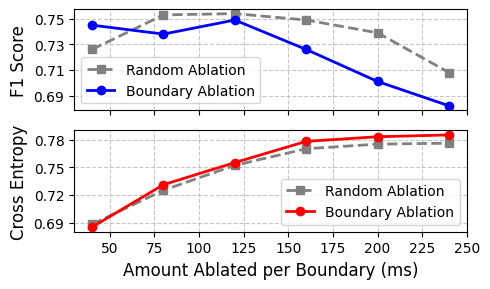

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('boundary_ablation.csv')

# Set up the figure and axes for two side-by-side plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 3))

# Plot 1: F1 Score comparison
ax1.plot(df['Amount ablated'] * 1000, df['Rand F1'], marker='s', label='Random Ablation', color='gray', linestyle='--', linewidth=2)
ax1.plot(df['Amount ablated'] * 1000, df['F1 score'], marker='o', label='Boundary Ablation', color='blue', linewidth=2)
#ax1.set_xlabel('Amount Ablated', fontsize=12)
ax1.set_ylabel('F1 Score', fontsize=12)
#ax1.set_title('Boundary Ablation Impact on F1 Score and Loss', fontsize=16)
ax1.legend()
ax1.xaxis.set_ticklabels([])
#ax1.xaxis.set_ticks([50, 100, 150, 200, 250])
ax1.yaxis.set_ticks([0.69, 0.71, 0.73, 0.75])
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot 2: Loss comparison
ax2.plot(df['Amount ablated'] * 1000, df['Rand Loss'], marker='s', label='Random Ablation', color='gray', linestyle='--', linewidth=2)
ax2.plot(df['Amount ablated'] * 1000, df['Loss'], marker='o', label='Boundary Ablation', color='red', linewidth=2)
ax2.set_xlabel('Amount Ablated per Boundary (ms)', fontsize=12)
ax2.set_ylabel('Cross Entropy', fontsize=12)
#ax2.set_title('Impact on Loss', fontsize=14)
ax2.legend(loc="lower right")
#ax2.xaxis.set_ticks([50, 100, 150, 200, 250])
ax2.yaxis.set_ticks([0.69, 0.72, 0.75, 0.78])
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.savefig("boundary-ablation-impact.pdf")
# Display the plots
plt.show()